# lab3: This is the title of the assignment

In [252]:
%pip install -r requirements.txt
%pip install imbalanced-learn
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Imports

Authors:  
AlaaAbdulrazzaq Abdulrazzaq  
Name Author 2  
(use double space to break lines on markdowns)

In [253]:
import numpy as np
import pandas as pd 
import matplotlib as mp
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns

## Load data

This section should load the raw dataset for the task.  
Remember to use relative paths to load any files in the notebook.

In [254]:
# Always use comments in the code to document specific steps
diabetes_Data = pd.read_csv('raw_data/diabetic_data.csv')
diabetes_Data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


## Task 1: Cleanup the data

This section handles the cleanup of the dataset and splitting of the data

In [255]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.over_sampling import SMOTE

Drop columns which have too many missing values, and replace "?" with NaN

In [256]:
diabetes_Data.replace("?", np.nan, inplace=True)

columns_to_drop = ['weight', 'payer_code', 'medical_specialty', 'encounter_id', 'patient_nbr']
diabetes_Data.drop(columns=columns_to_drop, inplace=True)

Encode age range into numeric values

In [257]:
age_mapping = {'[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, '[40-50)': 45,
               '[50-60)': 55, '[60-70)': 65, '[70-80)': 75, '[80-90)': 85, '[90-100)': 95}
diabetes_Data['age'] = diabetes_Data['age'].map(age_mapping)

Encode categorical variables with LabelEncoder

In [258]:
categorical_features = ['race', 'gender', 'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed']
le = LabelEncoder()
for col in categorical_features:
    diabetes_Data[col] = le.fit_transform(diabetes_Data[col].astype(str))

Convert readmitted column into binary taget variable

In [259]:
diabetes_Data['readmitted'] = diabetes_Data['readmitted'].map({'>30': 0, 'NO': 0, '<30': 1})

Convert medication values into numerical values

In [260]:
medication_columns = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
                      'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
                      'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
                      'examide', 'citoglipton', 'insulin', 'glyburide-metformin',
                      'glipizide-metformin', 'glimepiride-pioglitazone',
                      'metformin-rosiglitazone', 'metformin-pioglitazone']

medication_mapping = {'No': 0, 'Steady': 1, 'Up': 2, 'Down': -1}
for col in medication_columns:
    diabetes_Data[col] = diabetes_Data[col].map(medication_mapping)

Categorize diagnosis codes into broader groups

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Function to categorize diagnosis codes
def categorize_diagnosis(code):
    if pd.isna(code):
        return 'Other'
    code = str(code)
    if code.startswith("250"):  # Diabetes
        return 'Diabetes'
    elif code.startswith(("401", "402", "403", "404")):
        return 'Hypertension'
    elif code.startswith(("410", "411", "412", "413", "414")):
        return 'Ischemic Heart Disease'
    elif code.startswith("V"):
        return 'Other'
    else:
        return 'Other'

# Apply diagnosis categorization
diabetes_Data['diag_1'] = diabetes_Data['diag_1'].apply(categorize_diagnosis)
diabetes_Data['diag_2'] = diabetes_Data['diag_2'].apply(categorize_diagnosis)
diabetes_Data['diag_3'] = diabetes_Data['diag_3'].apply(categorize_diagnosis)

# One-hot encode diagnosis categories
diag_columns = ['diag_1', 'diag_2', 'diag_3']
diabetes_Data = pd.get_dummies(diabetes_Data, columns=diag_columns)

# Normalize numerical features
numerical_features = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
                      'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']
scaler = MinMaxScaler()
diabetes_Data[numerical_features] = scaler.fit_transform(diabetes_Data[numerical_features])

# Impute missing values using mean for numerical columns
diabetes_Data[numerical_features] = diabetes_Data[numerical_features].fillna(diabetes_Data[numerical_features].mean())

# Final dataset without SMOTE
diabetes_cleaned = diabetes_Data.copy()

# Verify that missing values were imputed
missing_values_after_imputation = diabetes_cleaned.isna().sum()
print("Missing values after imputation:")
print(missing_values_after_imputation)

# Save cleaned dataset
diabetes_cleaned.to_csv("cleaned_diabetes_data.csv", index=False)

print("Data cleaning and preprocessing complete! Saved as 'cleaned_diabetes_data.csv'.")
diabetes_cleaned.head()

Data cleaning and preprocessing complete! Saved as 'cleaned_diabetes_data.csv'.


,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,diag_1_Ischemic Heart Disease,diag_1_Other,diag_2_Diabetes,diag_2_Hypertension,diag_2_Ischemic Heart Disease,diag_2_Other,diag_3_Diabetes,diag_3_Hypertension,diag_3_Ischemic Heart Disease,diag_3_Other
0,2,0,5,6,25,1,0.000000,0.305344,0.000000,0.0000,...,False,False,False,False,False,True,False,False,False,True
1,2,0,15,1,1,7,0.153846,0.442748,0.000000,0.2125,...,False,True,True,False,False,False,False,False,False,True
2,0,0,25,1,1,7,0.076923,0.076336,0.833333,0.1500,...,False,True,True,False,False,False,False,False,False,True
3,2,1,35,1,1,7,0.076923,0.328244,0.166667,0.1875,...,False,True,True,False,False,False,False,True,False,False
4,2,1,45,1,1,7,0.000000,0.381679,0.000000,0.0875,...,False,True,False,False,False,True,True,False,False,False


Imputate data

Splitting the dataset: 70% training, 15% validation, 15% test

In [262]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load the cleaned dataset
df_cleaned = pd.read_csv("cleaned_diabetes_data.csv")

# Assuming df_cleaned is already loaded and preprocessed
X = df_cleaned.drop(columns=['readmitted'])
y = df_cleaned['readmitted']

# Split into 70% training and 30% temporary (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# No need for ADASYN anymore, just split the temporary set into 15% validation and 15% testing
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Dataset Split Sizes (No ADASYN applied):")
print(f"Training set: {len(X_train)} samples")
print(f"Validation set (No ADASYN): {len(X_val)} samples")
print(f"Test set (No ADASYN): {len(X_test)} samples")

Dataset Split Sizes (No ADASYN applied):
Training set: 71236 samples
Validation set (No ADASYN): 15265 samples
Test set (No ADASYN): 15265 samples


## Training

c:\Users\rambe\anaconda3\envs\lab3\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=100. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 6 folds for each of 9 candidates, totalling 54 fits
Best Parameters: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1}

--- best Performance ---

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     13562
           1       0.63      0.01      0.02      1703

    accuracy                           0.89     15265
   macro avg       0.76      0.51      0.48     15265
weighted avg       0.86      0.89      0.84     15265



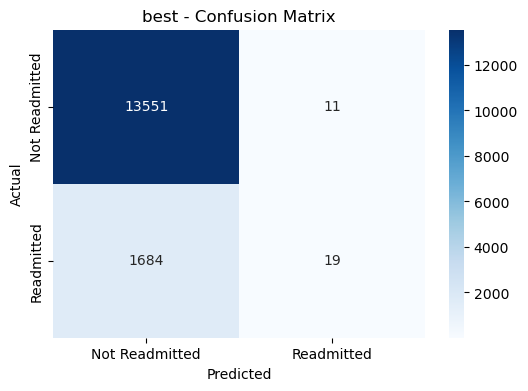

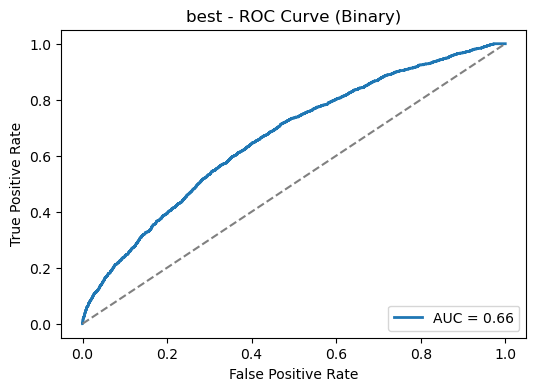

AUC Score: 0.66


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import utility_functions as uf

models = {
    "Logistic Regression": LogisticRegression(class_weight= 'balanced', max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(
        objective="binary:logistic",  # For binary classification
        random_state=42,
        device="cuda",
        class_weight="balanced",  # Handle imbalanced class weights
        n_estimators=100,  # Number of boosting rounds
        max_depth=6,  # Maximum depth of each tree
        learning_rate=0.1,  # Learning rate
        eval_metric="logloss",  # Evaluation metric
        verbosity=1)
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    uf.evaluate_model(model, X_test, y_test, name)


This section should contain:
- Results.
- Summary of best model performance:
    - Name of best model file as saved in /models.
    - Relevant scores such as: accuracy, precision, recall, F1-score, etc.
- Key discussion points.

In [ ]:
# Always use comments in the code to document specific steps